# Feature Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />


### Importing modules, configuring display options, and loading dataset 

In [1]:
# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# import warnings
# warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, f_classif, mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso

In [2]:
pd.set_option('display.max_columns', None) # display all the columns of a dataframe
pd.set_option('display.max_rows', 100)     # display 100 rows of a dataframe

In [91]:
# Load cleaned data - see "Data Cleansing.ipynb"
dataset = pd.read_csv('../ariel/Price_Data_cleaned.csv')

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Explore Dataset

#### Variable types

In [ ]:
'BsmtQual', 'BsmtCond','BsmtFinType1', 'BsmtFinType1', 'BsmtUnfSF', 'TotalBsmtSF'
'ExterCond', 'ExterQual','OverallQual', 'OverallCond', 'Exterior1st', 'Exterior2nd'
'GarageFinish', 'GarageQual', 'GarageCond',
'MasVnrType', 'MasVnrArea'
'HeatingQC', 
'KitchenAbvGr', 'KitchenQual',
'Fireplaces', 'FireplaceQu'
'LowQualFinSF',
'PavedDrive', 'Fence',
# y = beta0 + beta1*X1 + beta2*X2 + beta3*X3 + beta4*X4 ...+ betan*Xn(Exterior Quality)

In [99]:
continues_variables = ['GrLivArea', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'WoodDeckSF',
                       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
                       'SalePrice', 'LotFrontage']

discrete_variables = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                      'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
                      'MoSold', 'YrSold']

categorical_nominal_variables = ['MSSubClass', 'Alley', 'LandContour', 'MSZoning', 'LotConfig', 'Neighborhood',
                                 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
                                 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Street', 'Heating',
                                 'GarageType', 'CentralAir', 'MiscFeature', 'SaleType', 'SaleCondition']

categorical_ordinal_variables = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                                 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 
                                 'GarageFinish', 'PavedDrive', 'Fence', 'Functional', 'BsmtFinType2', 'Electrical',
                                 'BsmtFinType1','BsmtExposure', 'LandSlope', 'Utilities', 'LotShape',]


#### Converting Categorical Variables to Ordinal Variables

In [110]:
# Encoding Ordinal Variables
dict_1 = {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
dict_2 = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
dict_3 = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
dict_4 = {"None":0, "Unf":1, "RFn":2, "Fin":3}
dict_5 = {"N":1, "P":2, "Y":3}
dict_6 = {"None":0, "MnWw":1, "GdWo":2, "MnPrv":3, "GdPrv":4}
dict_7 = {"Sal":1, "Sev":2, "Maj2":3, "Maj1":4, "Mod":5, "Min2":6, "Min1":7, "Typ":8}
dict_8 = {"Mix":1, "FuseP":2, "FuseF":3, "FuseA":4, "SBrkr":5}
dict_9 = {"Sev":1, "Mod":2, "Gtl":3}
dict_10 = {"ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub":4}
dict_11 = {"IR3":1, "IR2":2, "IR1":3, "Reg":4}

dataset.BsmtExposure.replace(dict_1, inplace=True)
dataset.ExterQual.replace(dict_2, inplace=True)
dataset.ExterCond.replace(dict_2, inplace=True)
dataset.BsmtQual.replace(dict_2, inplace=True)
dataset.BsmtCond.replace(dict_2, inplace=True)
dataset.HeatingQC.replace(dict_2, inplace=True)
dataset.KitchenQual.replace(dict_2, inplace=True)
dataset.FireplaceQu.replace(dict_2, inplace=True)
dataset.GarageQual.replace(dict_2, inplace=True)
dataset.GarageCond.replace(dict_2, inplace=True)
dataset.PoolQC.replace(dict_2, inplace=True)
dataset.BsmtFinType1.replace(dict_3, inplace=True)
dataset.BsmtFinType2.replace(dict_3, inplace=True)
dataset.GarageFinish.replace(dict_4, inplace=True)
dataset.PavedDrive.replace(dict_5, inplace=True)
dataset.Fence.replace(dict_6, inplace=True)
dataset.Functional.replace(dict_7, inplace=True)
dataset.Electrical.replace(dict_8, inplace=True)
dataset.LandSlope.replace(dict_9, inplace=True)
dataset.Utilities.replace(dict_10, inplace=True)
dataset.LotShape.replace(dict_11, inplace=True)


#### Converting Categorical Variable to Dummy Variables

In [135]:
# set the MSSubClass column to object, since it is a nominal variable
dataset['MSSubClass'] = dataset['MSSubClass'].astype(object)

In [136]:
# new dataset that will hold the encoded categorical variables + all the others
dataset_encoded = dataset.copy()

In [137]:
# Encode all categorical nominal variables
for column_name in categorical_nominal_variables:
    dataset_encoded = pd.concat([dataset_encoded, pd.get_dummies(dataset_encoded[column_name], prefix=column_name, drop_first=True)], axis=1)

In [138]:
# Remove original categorical columns
dataset_encoded = dataset_encoded.drop(categorical_nominal_variables, axis=1)

In [223]:
dataset_encoded

,GrLivArea,SalePrice,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,Alley_None,Alley_Pave,LandContour_HLS,LandContour_Low,LandContour_Lvl,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Street_Pave,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,CentralAir_Y,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,856,126000,64.0,7890,4,4,3,6,6,1939,1950,0.0,3,3,3,3,1,3,238.0,1,0.0,618.0,856.0,3,5,856,0,0,1.0,0.0,1,0,2,1,3,4,8,1,4,1939.0,1,2.0,399.0,3,3,3,0,0,0,0,166,0,0,0,0,3,2010,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,1049,139500,42.0,4235,4,4,3,5,5,1984,1984,149.0,4,3,4,3,2,6,552.0,5,393.0,104.0,1049.0,3

#### MultiCollinearity

In [116]:
# Generate correlation matrix (continues variables only)
corr_matrix = dataset[continues_variables].corr(method="pearson") # pearson? kendall? which is best

In [134]:
# List of highly (>0.79) correlated pair of variables
c_m = list(corr_matrix.columns)
for index_ in corr_matrix.columns:
    c_m.remove(index_)
    for feature in c_m:
        if abs(corr_matrix.loc[index_,feature])>0.7:
            print(index_,"_",feature,": ",corr_matrix.loc[index_,feature], sep="")

GrLivArea_SalePrice: 0.7199799401450586
TotalBsmtSF_1stFlrSF: 0.7842803487175525


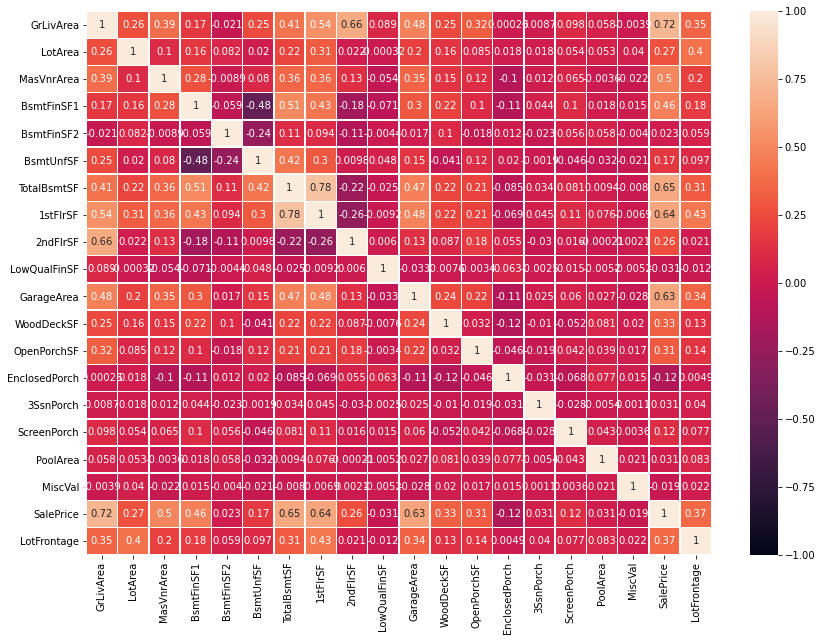

In [133]:
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, linewidths=.5, annot=True)

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Feature Selection

#### Using Lasso Regression to Select Features

In [260]:
X = dataset_encoded.drop('SalePrice',axis=1)  # features
y = dataset_encoded['SalePrice']         # target
X_norm = MinMaxScaler().fit_transform(X)      # Transform features by scaling each feature to a given range.

In [271]:
num_f = 10 # number of features to select
# SelectFromModel -> Meta-transformer for selecting features based on importance weights.
embeded_lr_selector = SelectFromModel(Lasso(alpha=0.001), max_features=num_f)
# Penalty="l1" -> indicates regularization using L1
embeded_lr_selector.fit(X_norm, y) # Fit the SelectFromModel meta-transformer.

embeded_lr_support = embeded_lr_selector.get_support() # Get a mask, or integer index, of the features selected
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist() # List of features
print(str(len(embeded_lr_feature)), 'selected features')

10 selected features


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543107957916.1428, tolerance: 1451865022.2764199
  model = cd_fast.enet_coordinate_descent(


In [272]:
# embeded_lr_feature
# list_features = [x[0:(x.find("_"))] for x in embeded_lr_feature]
list_features = []
for column_name in embeded_lr_feature:
    if '_' in column_name:
        list_features.append(column_name[0:column_name.find("_")])
    else:
        list_features.append(column_name)


In [273]:
embeded_lr_feature

['GrLivArea',
 'LotArea',
 'OverallQual',
 'BsmtFinSF1',
 '1stFlrSF',
 'PoolArea',
 'PoolQC',
 'Neighborhood_GrnHill',
 'Condition2_PosA',
 'Condition2_PosN']

In [228]:
list_feat = set(list_features)

In [229]:
dataset[list_feat].dtypes.sort_values()

1stFlrSF          int64
OverallQual       int64
LotArea           int64
PoolQC            int64
PoolArea          int64
GrLivArea         int64
BsmtFinSF1      float64
Neighborhood     object
Condition2       object
dtype: object

In [235]:
list(list_feat)

['Neighborhood',
 '1stFlrSF',
 'OverallQual',
 'Condition2',
 'LotArea',
 'PoolQC',
 'PoolArea',
 'BsmtFinSF1',
 'GrLivArea']

#### Using F Test to Select Features

In [153]:
value_f, p_f = f_classif(X_norm, y)
pd.Series(p_f, index=X.columns).sort_values().head(20)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


SaleCondition_Partial     0.000000e+00
SaleType_New              0.000000e+00
Exterior1st_ImStucc       0.000000e+00
Condition2_RRAn           0.000000e+00
Condition2_PosN           0.000000e+00
MSSubClass_150            0.000000e+00
SaleCondition_Alloca     8.146065e-305
OverallQual              3.640980e-271
Condition2_PosA          3.008646e-213
GrLivArea                2.544883e-177
Street_Pave              1.161482e-171
ExterQual                2.922177e-141
Neighborhood_NridgHt     2.191582e-135
Neighborhood_NoRidge     8.940149e-124
1stFlrSF                 1.045746e-112
TotalBsmtSF              3.097936e-111
KitchenQual              2.109207e-108
GarageCars               5.613187e-107
GarageArea                1.012057e-98
BsmtQual                  4.494704e-94
dtype: float64

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Descriptive Modeling

#### Train and Test data

In [230]:
# Split data 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### Multiple Linear Regression (All the variables)

In [262]:
mlr_model = LinearRegression()
mlr_model.fit(X_train,np.log(y_train))

LinearRegression()

In [264]:
mlr_model.score(X_train,np.log(y_train))

0.9387712279193521

In [265]:
# Overfitting when using all the features to train the model
mlr_model.score(X_test,np.log(y_test))

-979730633.8517914

<hr>

#### Linear Model with limited variables

In [182]:
temp_col = ['Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide','Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens','Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk',
 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes','Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU','Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker'] + ['GrLivArea','LotArea','OverallQual','OverallCond','TotalBsmtSF','YearBuilt',]

In [287]:
# X_train.filter(like="Neighborhood").columns.tolist() 
# X_train.filter(like="Condition2").columns.tolist()
temp_col = ['1stFlrSF','OverallQual','LotArea','BsmtFinSF1','GrLivArea']
# pd.concat(X_train[['1stFlrSF','OverallQual','LotArea','BsmtFinSF1','GrLivArea']],X_train.filter(like="Neighborhood"),X_train.filter(like="Condition2"))

In [288]:
mlr_model.fit(X[temp_col], np.log(y))
mlr_model.score(X_train[temp_col], np.log(y_train))

0.8179483840437746

In [289]:
mlr_model.score(X_test[temp_col], np.log(y_test))

0.8466842662465299

In [290]:
X[temp_col].columns

Index(['1stFlrSF', 'OverallQual', 'LotArea', 'BsmtFinSF1', 'GrLivArea'], dtype='object')

In [291]:
mlr_model.coef_

array([1.20044559e-04, 1.52304430e-01, 3.48673507e-06, 1.59606945e-04,
       2.42077173e-04])

In [ ]:
# y = beta0 + beta1*X1 + beta2*X2 + beta3*X3 + betaa4*X4 ...+ betan*Xn(Exterior Quality)

<hr>

In [292]:
# adding Kitche Quality
temp_col_k = ['1stFlrSF','OverallQual','LotArea','BsmtFinSF1','GrLivArea','KitchenQual']

In [293]:
mlr_model.fit(X[temp_col_k], np.log(y))
mlr_model.score(X_train[temp_col_k], np.log(y_train))

0.8271958491647387

In [294]:
mlr_model.score(X_test[temp_col_k], np.log(y_test))

0.8611562658893162

In [297]:
X_test[temp_col_k].columns

Index(['1stFlrSF', 'OverallQual', 'LotArea', 'BsmtFinSF1', 'GrLivArea',
       'KitchenQual'],
      dtype='object')

In [296]:
mlr_model.coef_

array([1.09019400e-04, 1.29523872e-01, 3.68042719e-06, 1.53635470e-04,
       2.36137944e-04, 8.41670042e-02])

<hr>

                  SalePrice
Neighborhood               
Blmngtn       196237.173913
BrDale        118000.000000
BrkSide       143885.869565
ClearCr       255600.000000
CollgCr       211553.609195
Crawfor       229301.346154
Edwards       156082.916667
Gilbert       197479.908163
Greens        213750.000000
GrnHill       330000.000000
IDOTRR        128381.461538
MeadowV        96500.000000
Mitchel       173360.000000
NAmes         159376.811594
NWAmes        197471.428571
NoRidge       330705.185185
NridgHt       313662.495868
OldTown       138107.753846
SWISU         156619.142857
Sawyer        142745.652174
SawyerW       188364.288889
Somerst       229281.302817
StoneBr       373513.640000
Timber        264623.875000
Veenker       278150.000000
                  SalePrice
Neighborhood               
Blueste       143590.000000
BrDale        105669.642857
BrkSide       120896.250000
ClearCr       208035.200000
CollgCr       160469.354839
Crawfor       191350.560606
Edwards       123744

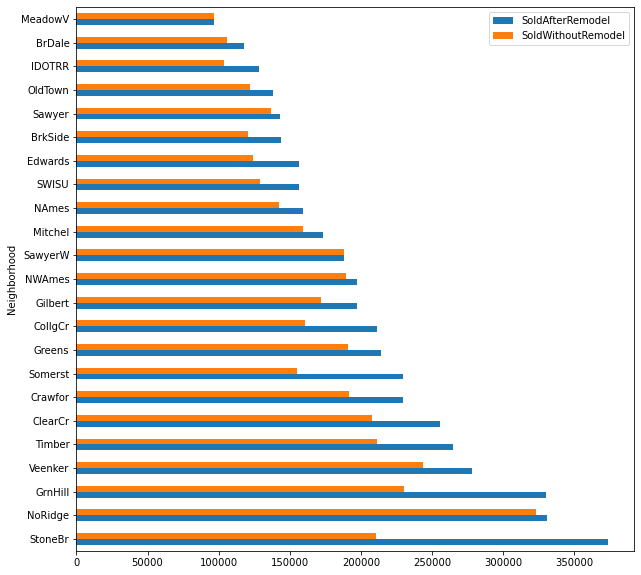

In [257]:
dataset['Year.Diff'] = dataset['YrSold']- dataset['YearRemodAdd']
within = pd.DataFrame(dataset[dataset['Year.Diff']<=10].groupby('Neighborhood')['SalePrice'].mean())
print(within)
out = pd.DataFrame(dataset[dataset['Year.Diff']>10].groupby('Neighborhood')['SalePrice'].mean())
print(out)
RemodelDif = pd.merge(within, out, left_on='Neighborhood', right_on = "Neighborhood", how='outer').reset_index()
RemodelDif.columns=['Neighborhood','SoldAfterRemodel','SoldWithoutRemodel']
RemodelDif1 = RemodelDif.drop(RemodelDif.index[[0,16,25,26,27]]).set_index('Neighborhood').sort_values(by = "SoldAfterRemodel", axis=0, ascending = False)
print(RemodelDif1)
RemodelDif1.plot(kind='barh', figsize=(10,10))